# Install Dependencies

In [1]:
%%capture
!pip install monai

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/Machine-Learning-Biomedicine/PankVision-3D/model/get_model.py /content
!cp /content/drive/MyDrive/Machine-Learning-Biomedicine/PankVision-3D/preprocess/final_preprocess.py /content

In [4]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference
from final_preprocess import prepare
from get_model import get_model

# Load Model Statistics

In [5]:
# Model List
!ls /content/drive/MyDrive/Machine-Learning-Biomedicine/PankVision-3D/results/dataset-007

 v1			     'v3 (resunet)'		  v5	      v7
'v2 (dropout0.2-200epochs)'  'v4 (enhanced_preprocess)'   v6dynunet


In [6]:
in_dir = '/content/drive/MyDrive/Machine-Learning-Biomedicine/PankVision-3D/dataset/dataset-007/Data_Train_Test'
model_dir = '/content/drive/MyDrive/Machine-Learning-Biomedicine/PankVision-3D/results/dataset-007/v6dynunet'
# models: version 2 (dropout0.2-200epochs)
# version 4 (enhanced_preprocess) best model thus far
# v5 performed decently but overfit at 36 epochs
# v6dynunet performed amazing (best model thus far)

In [7]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))
loss_std_train = np.load(os.path.join(model_dir, 'loss_std_train.npy'))
metric_std_train = np.load(os.path.join(model_dir, 'metric_std_train.npy'))

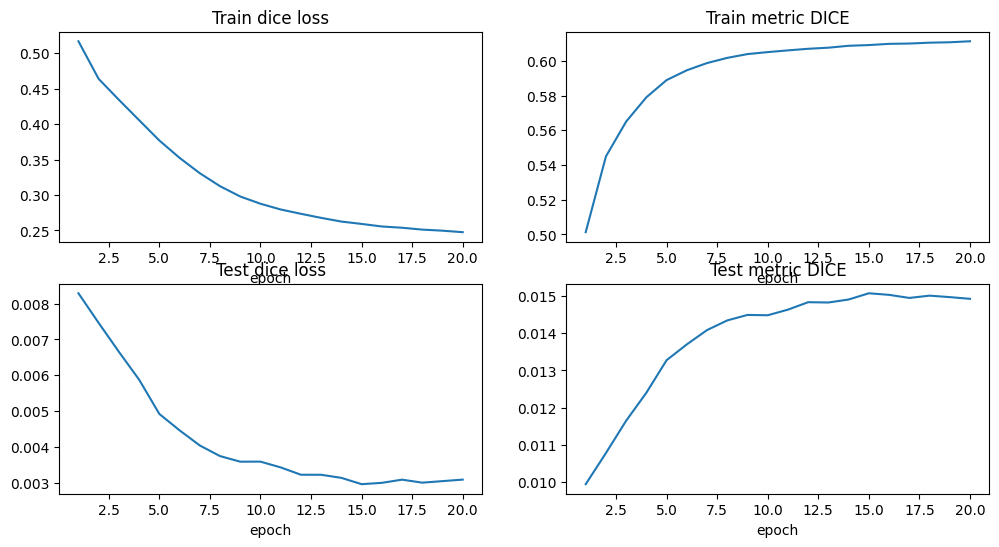

In [ ]:
plt.figure("Results 25 August", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

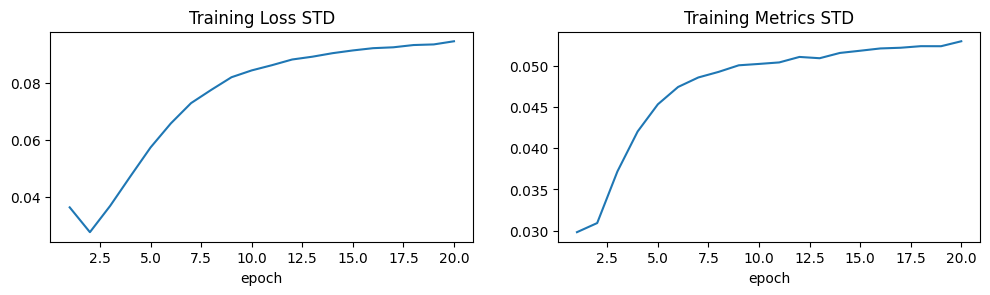

In [ ]:
plt.figure("Standard Deviations", (12, 6))

plt.subplot(2, 2, 1)
plt.title("Training Loss STD")
x = [i + 1 for i in range(len(loss_std_train))]
y = loss_std_train
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Training Metrics STD")
x = [i + 1 for i in range(len(metric_std_train))]
y = metric_std_train
plt.xlabel("epoch")
plt.plot(x, y)

# Process the images before feeding into model

## Transforms, Resizing

In [ ]:
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[6:8]

test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),
        ToTensord(keys=["vol", "seg"]),
    ]
)

test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

## CLAHE

In [8]:
from skimage import exposure

def preprocess_image(image, a_min=-200, a_max=200):
    adjusted_image = (image - 60 + 200) / 400
    normalized_image = (adjusted_image - np.min(adjusted_image)) / (np.max(adjusted_image) - np.min(adjusted_image))
    # convert the PyTorch tensor to a NumPy array
    normalized_image_np = normalized_image.numpy()
    enhanced_image = exposure.equalize_adapthist(normalized_image_np)
    return enhanced_image

def prepare_test(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=False):
    set_determinism(seed=0)

    def combined_transforms(data):

        enhanced_vol = preprocess_image(data["vol"], a_min=a_min, a_max=a_max)

        return {"vol": enhanced_vol, "seg": data["seg"]}

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
    test_files = test_files[6:8]

    combined_test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            # Applying the combined preprocessing function here
            combined_transforms,
            ToTensord(keys=["vol", "seg"]),
        ]
    )

    test_ds = Dataset(data=test_files, transform=combined_test_transforms)
    test_loader = DataLoader(test_ds, batch_size=1)

    return test_loader

test_loader = prepare_test(in_dir)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if ima

# Models

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args = {
    'model_name': 'DynUNet',
    'pretrained': True,
    'dropout': 0.1
}
model = get_model(args)
model = model.to(device)

## Show Model Components

In [10]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

DynUNet(
  (input_block): UnetResBlock(
    (conv1): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (D): Dropout(p=0.1, inplace=False)
      )
    )
    (conv2): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (D): Dropout(p=0.1, inplace=False)
      )
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv3): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (adn): ADN(
        (D): Dropout(p=0.1, inplace=False)
      )
    )
    (norm3): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
  (downsamples): Modul

# Visualizing by Slices of 30

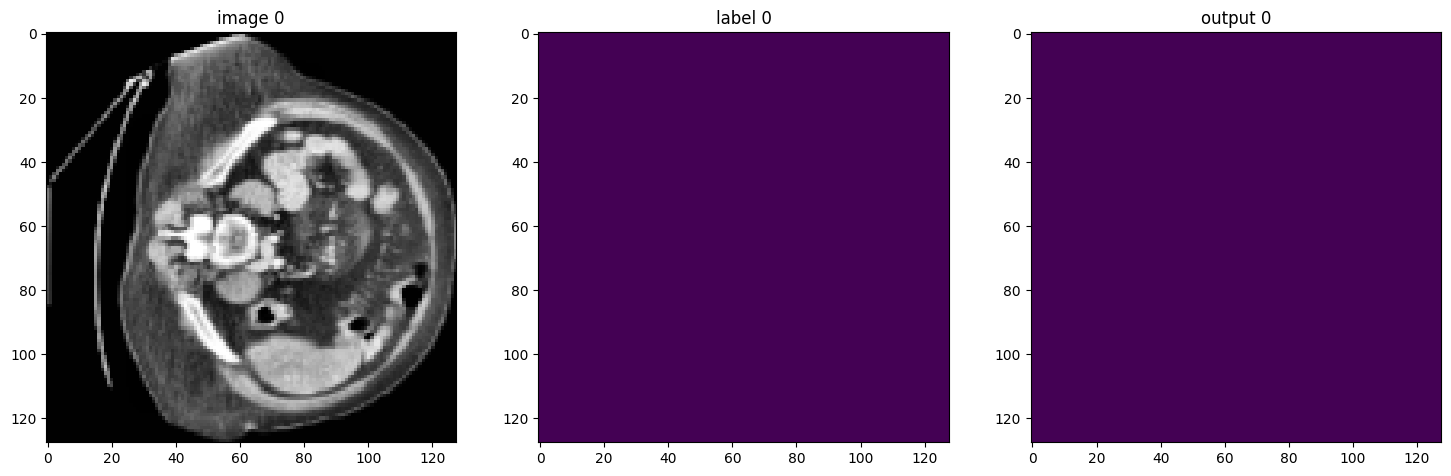

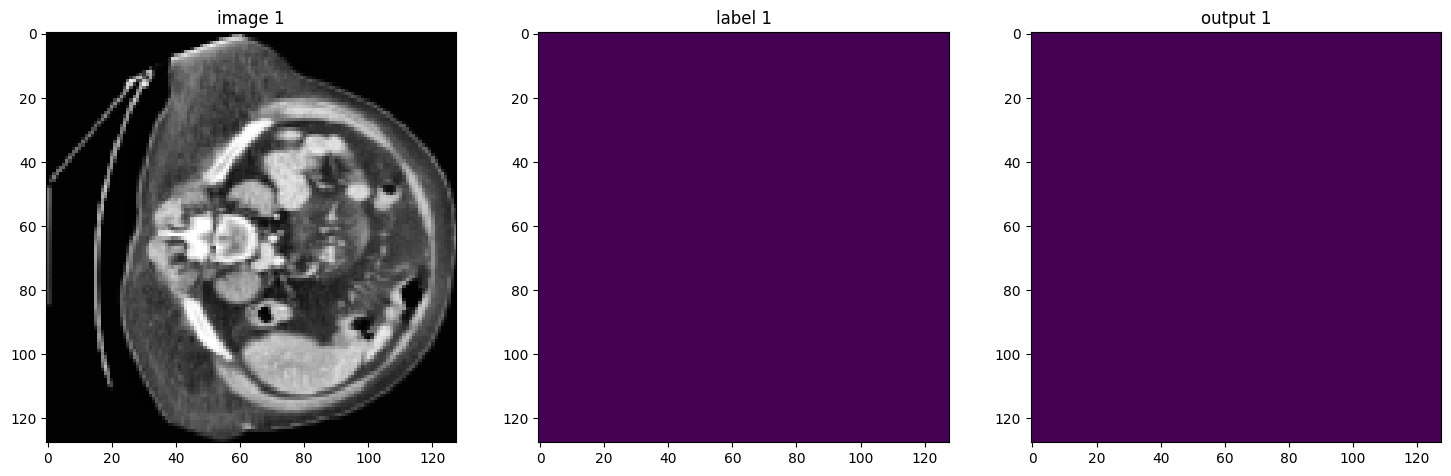

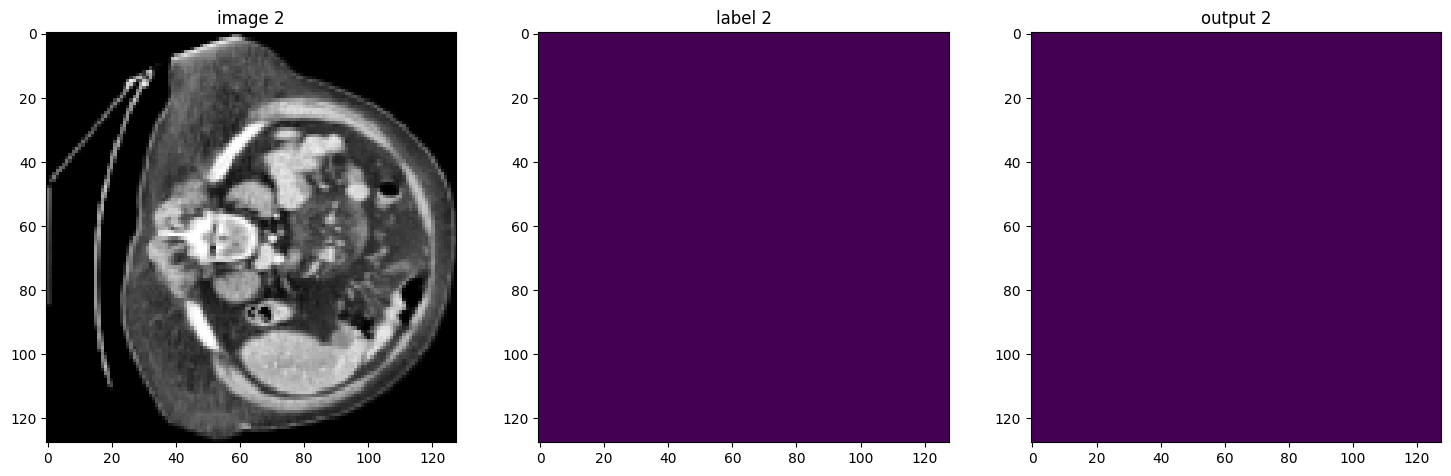

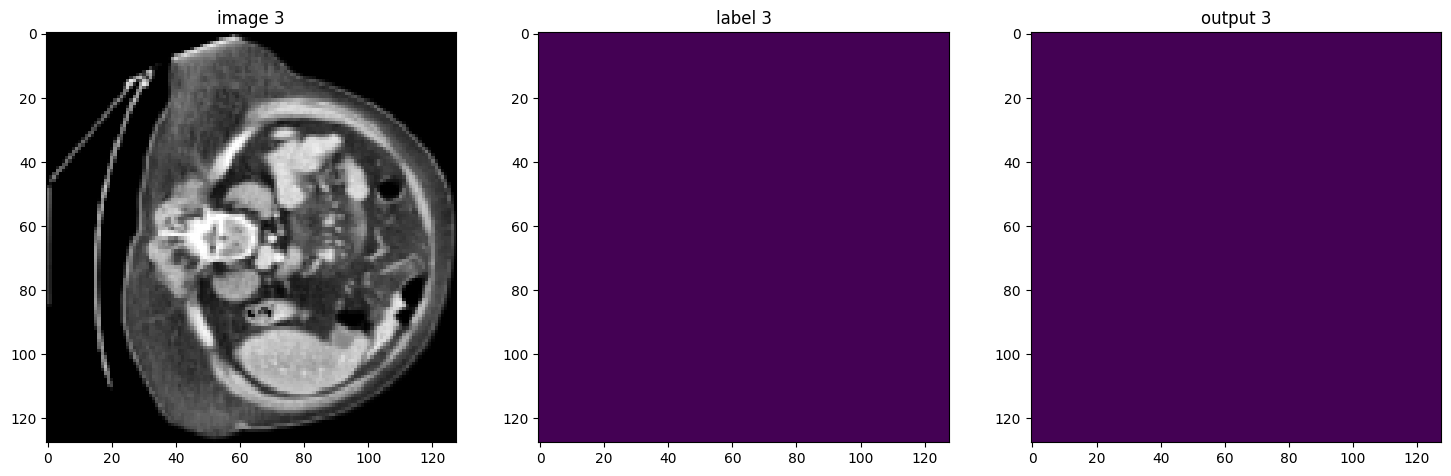

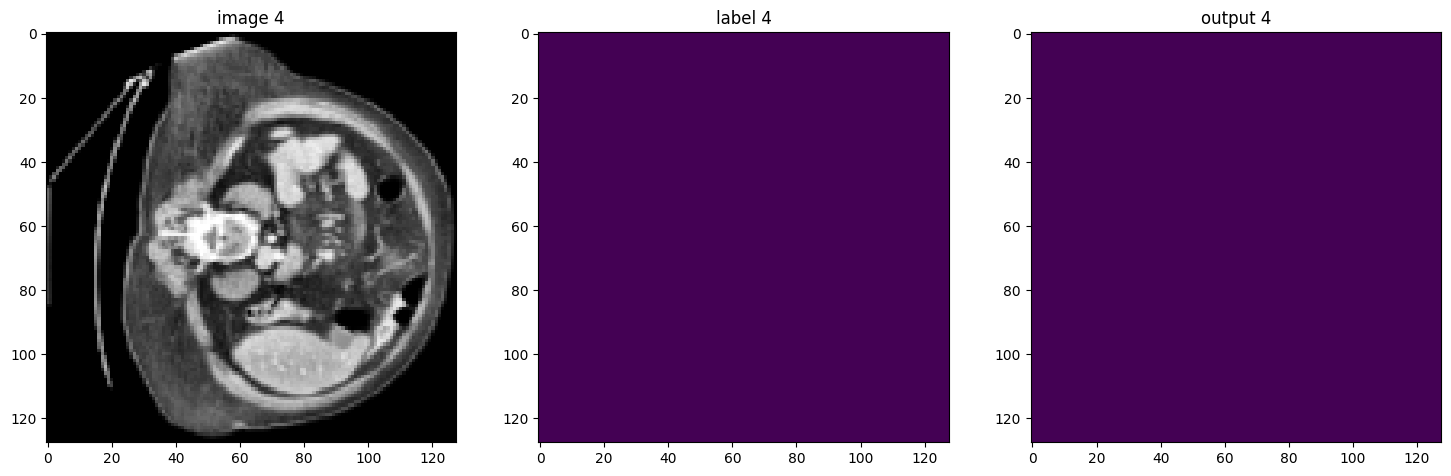

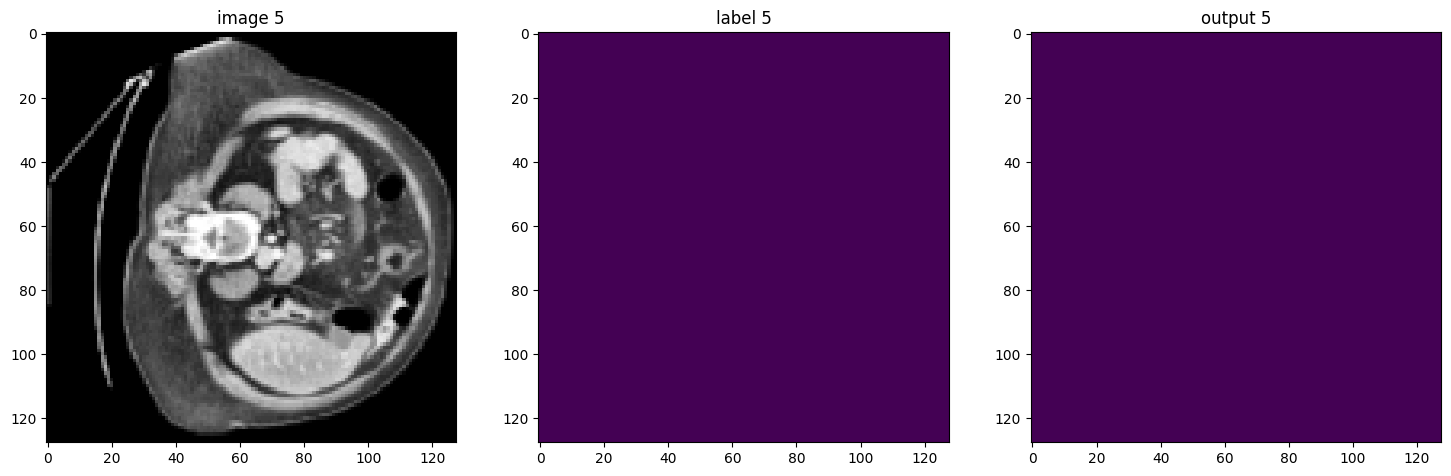

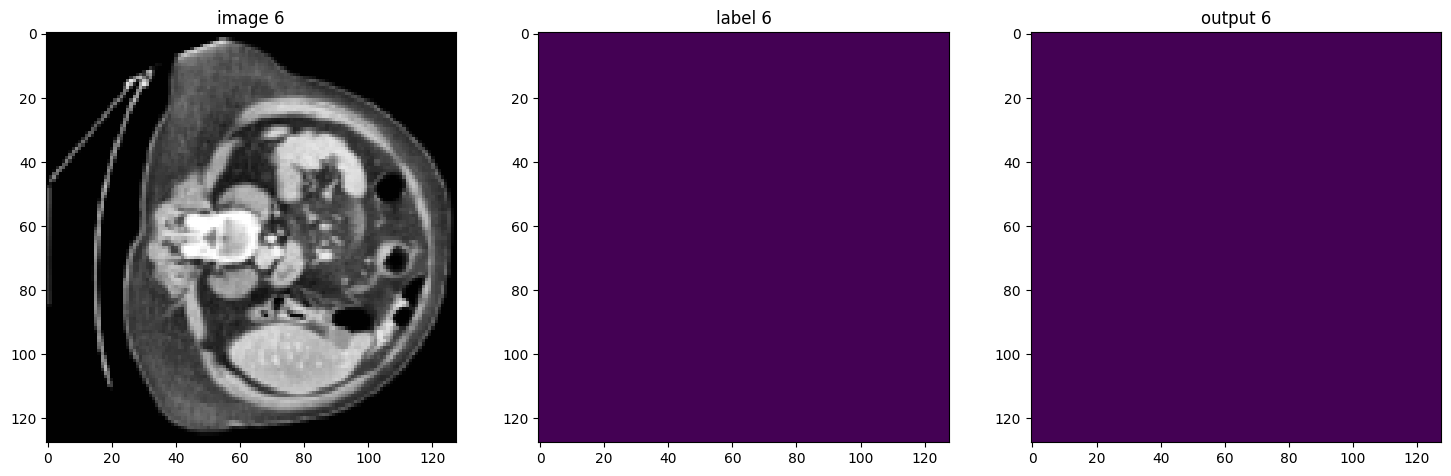

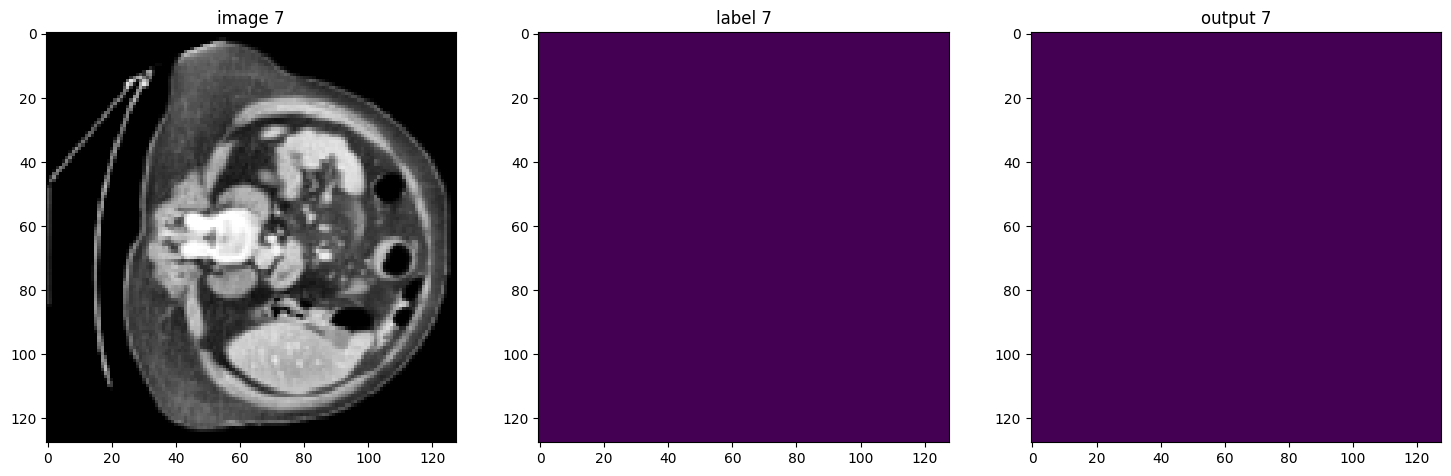

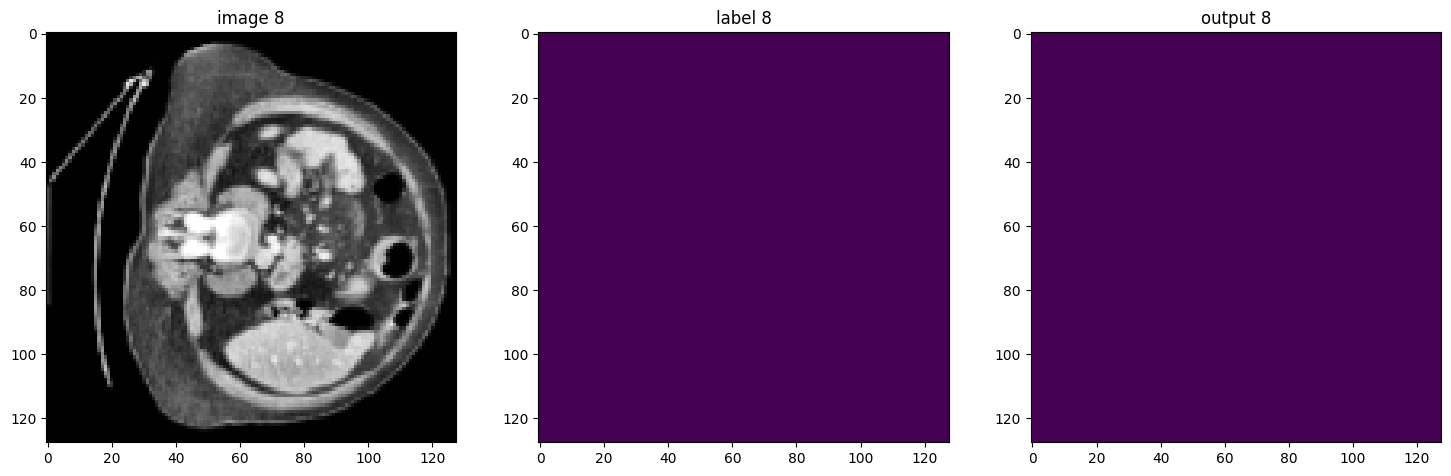

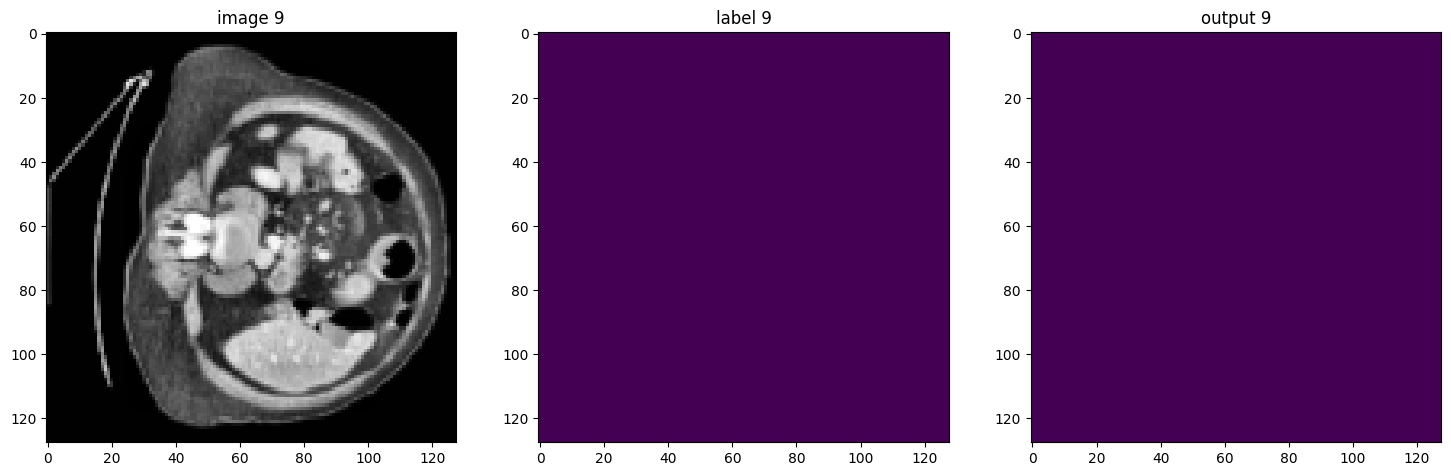

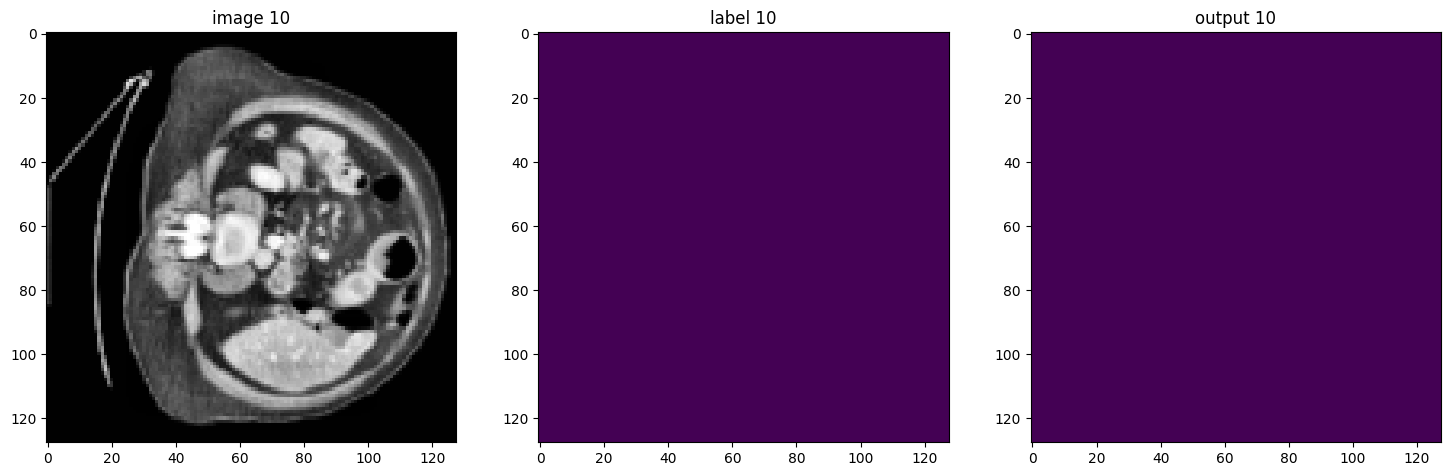

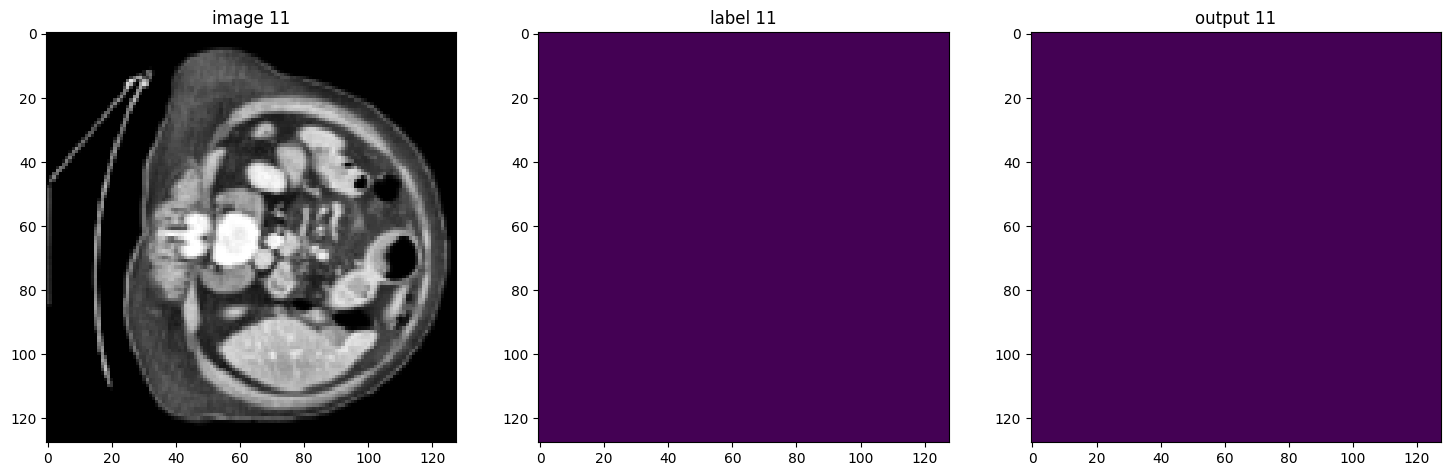

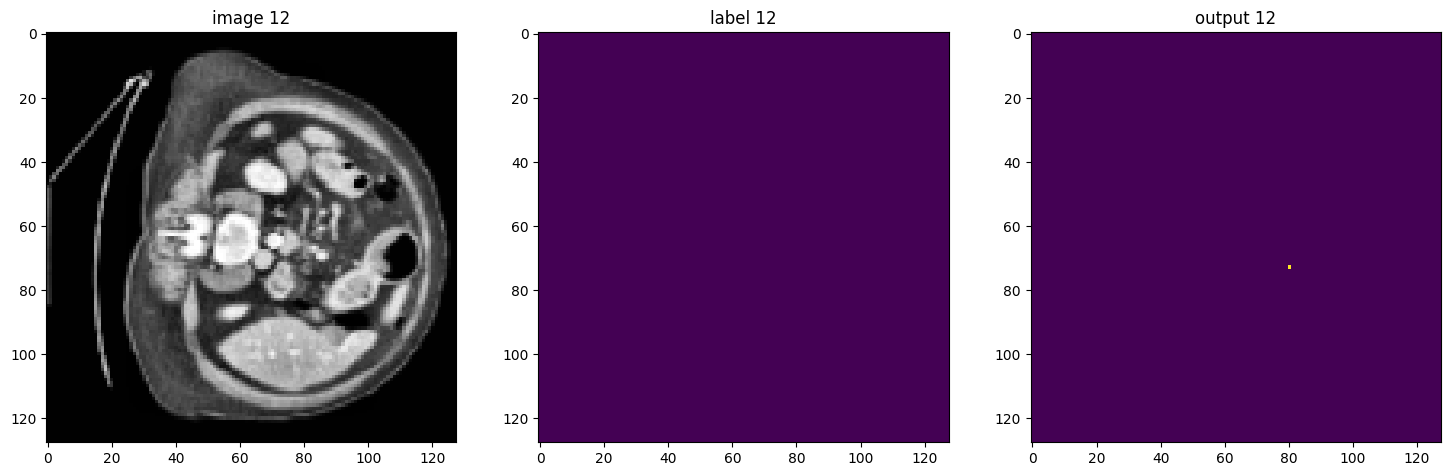

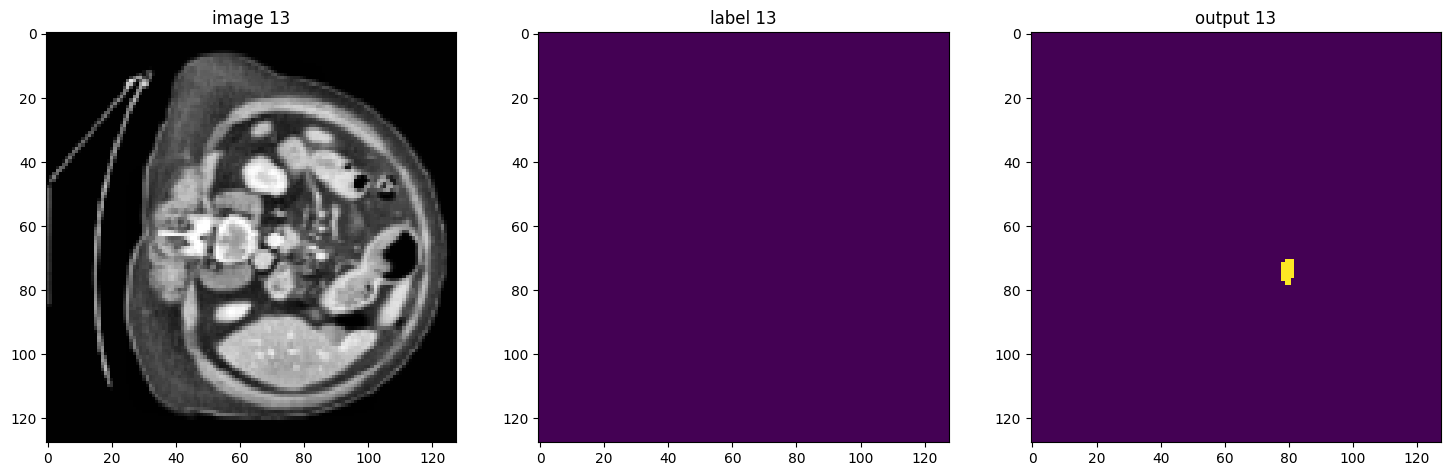

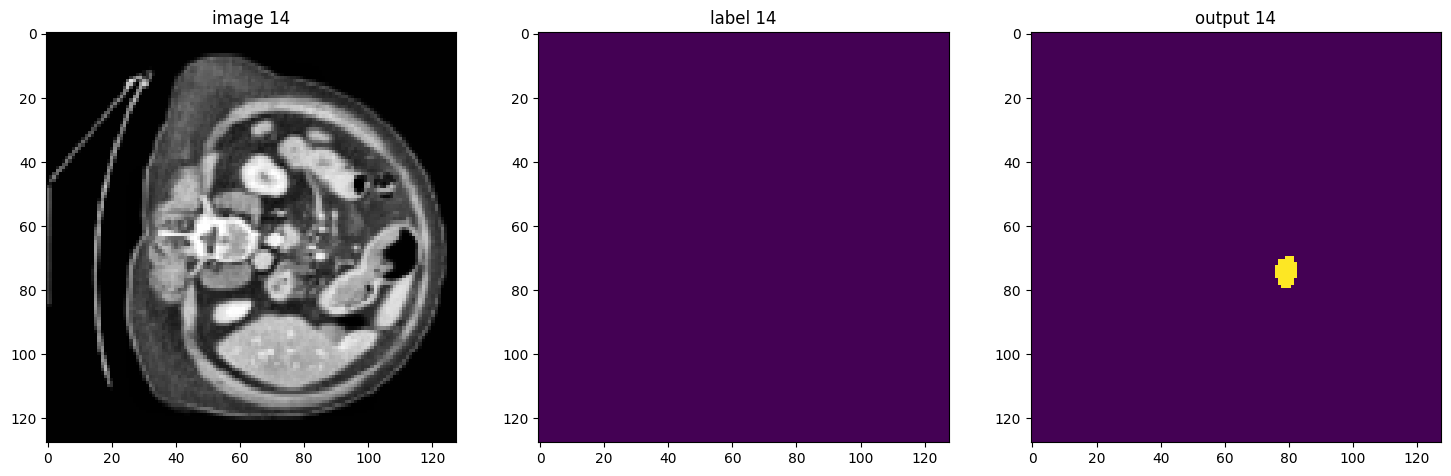

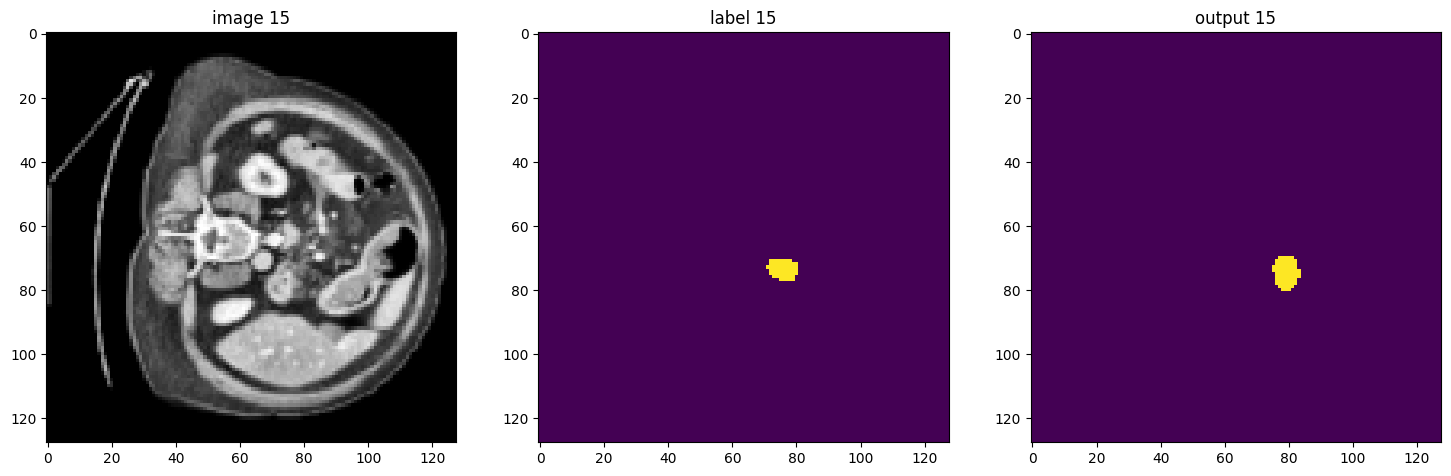

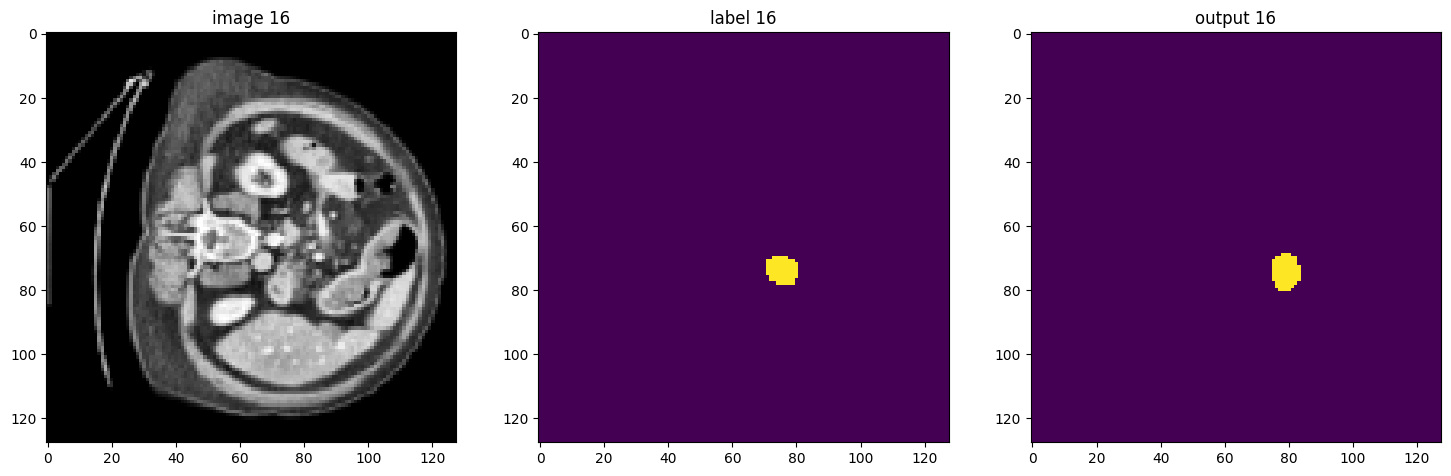

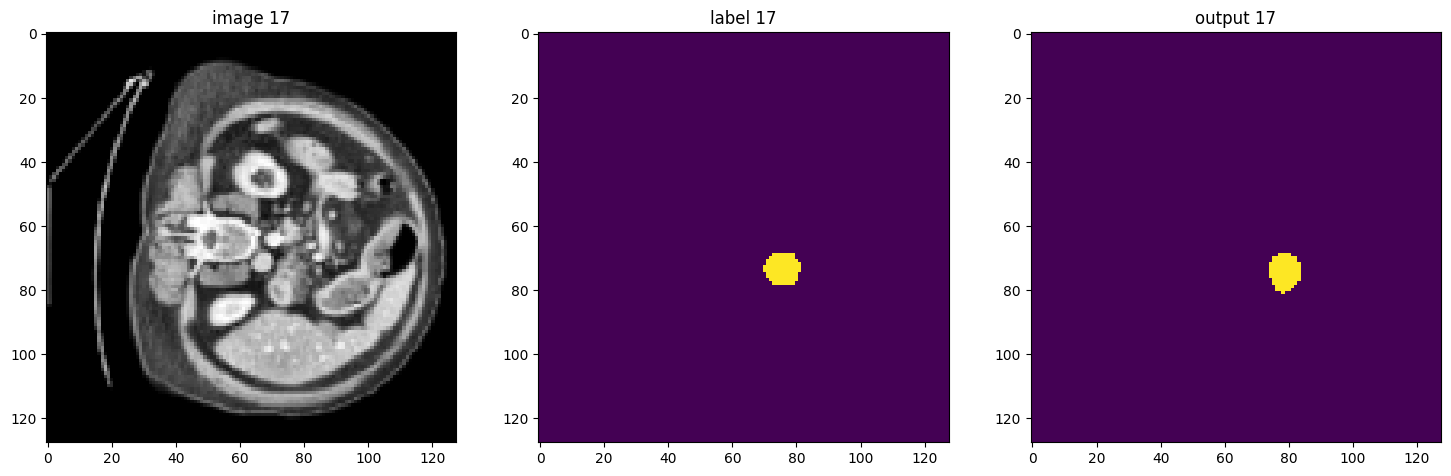

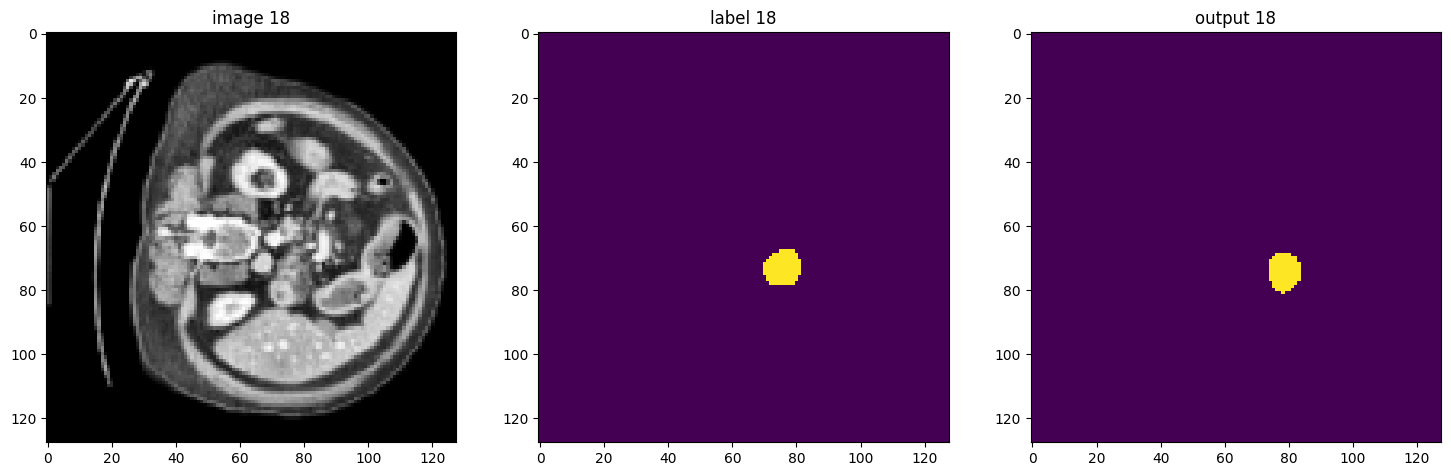

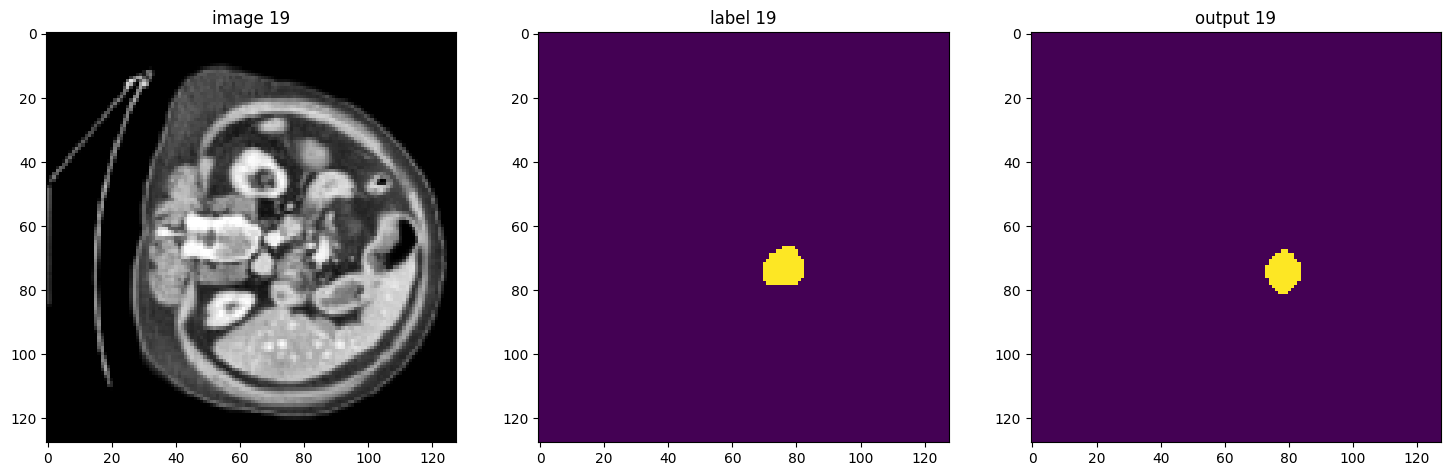

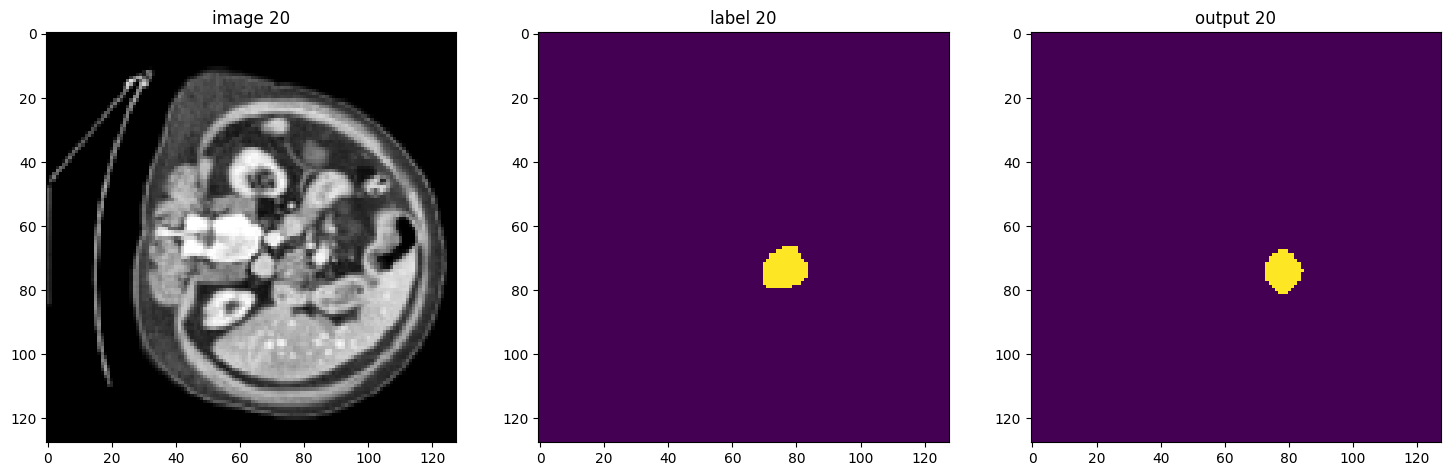

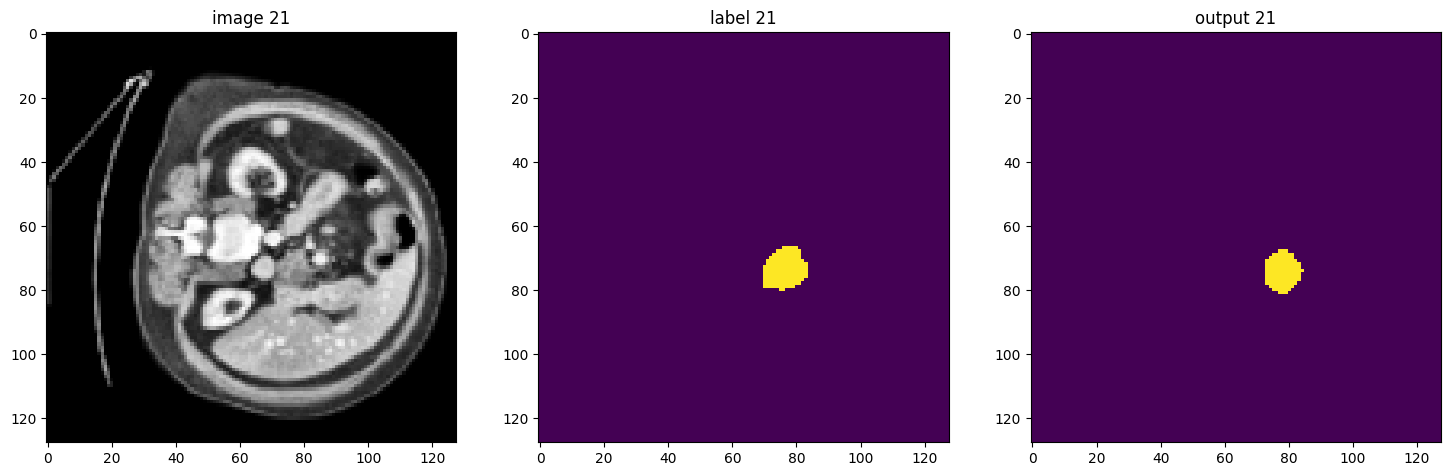

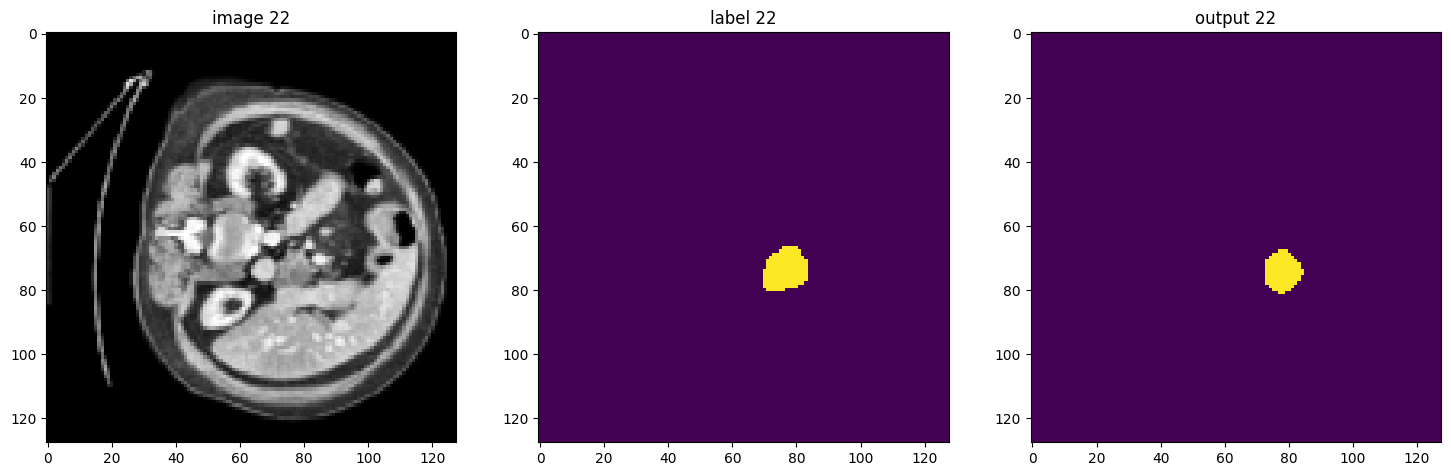

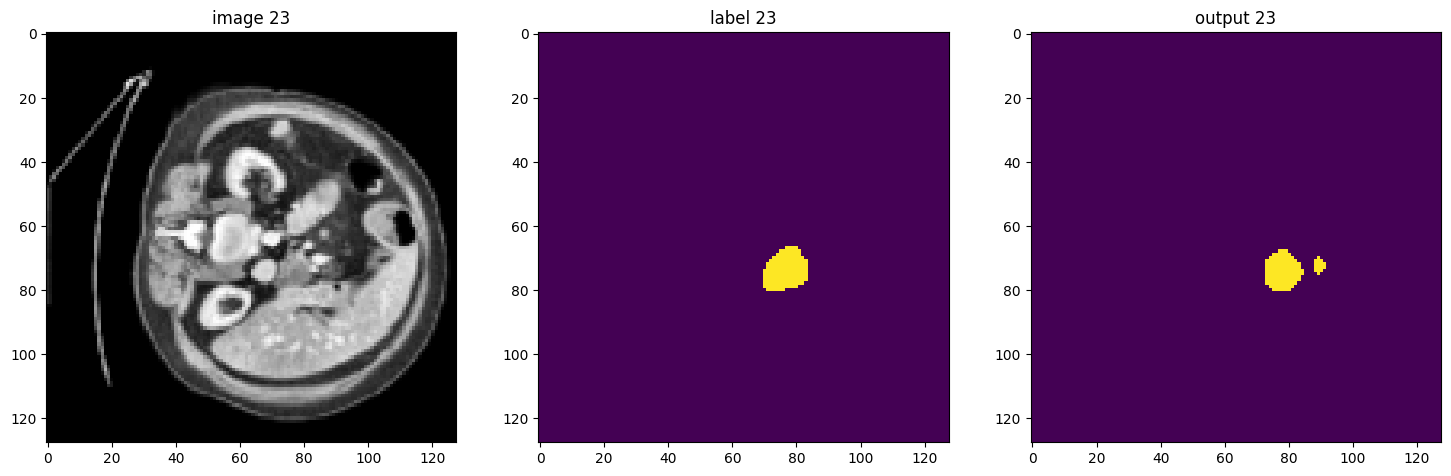

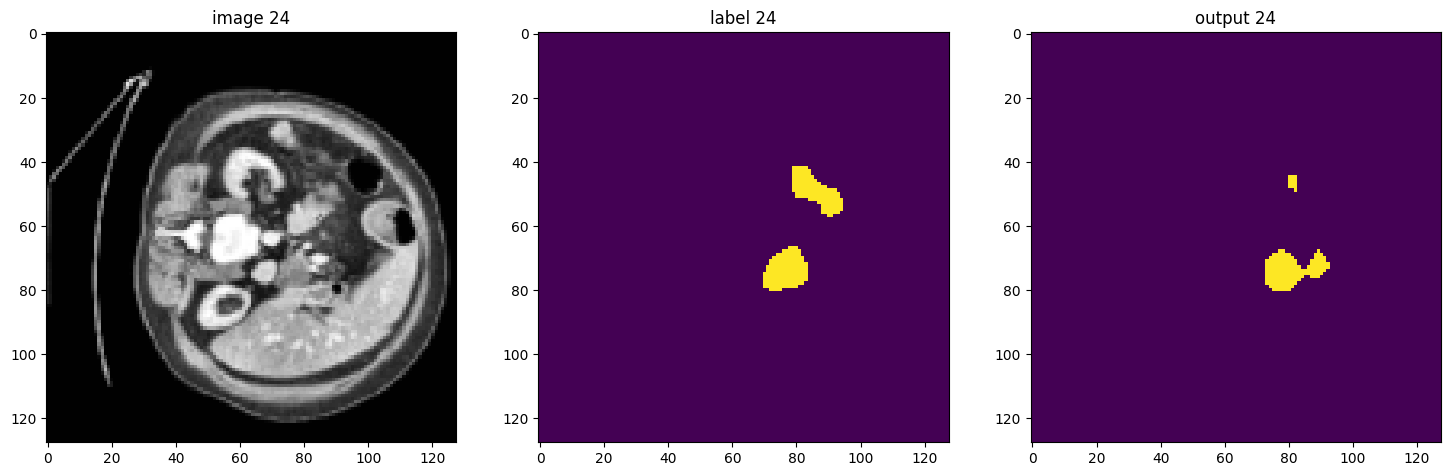

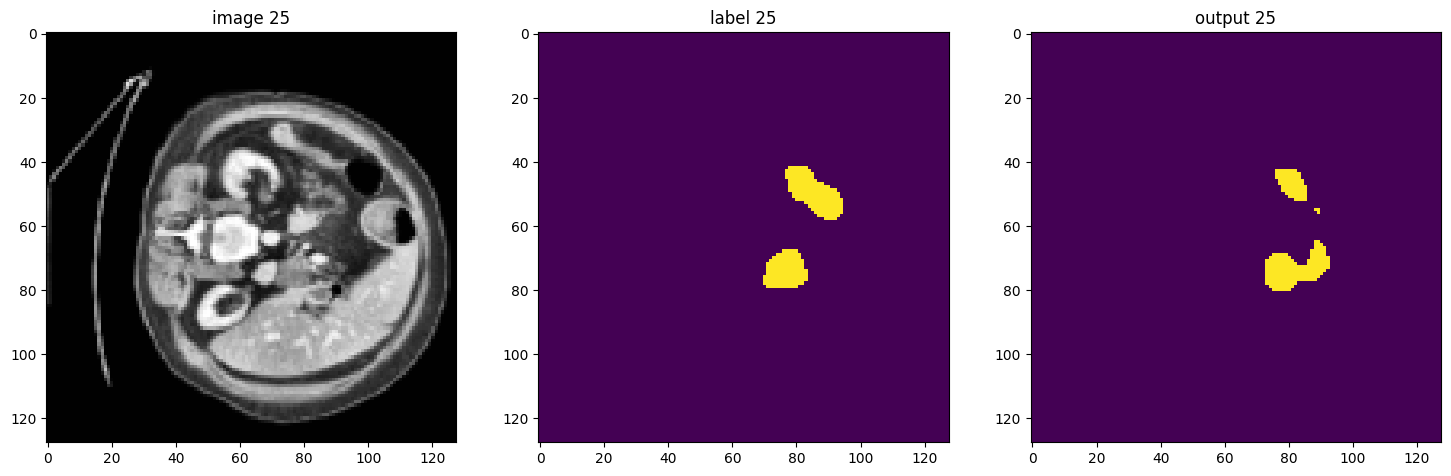

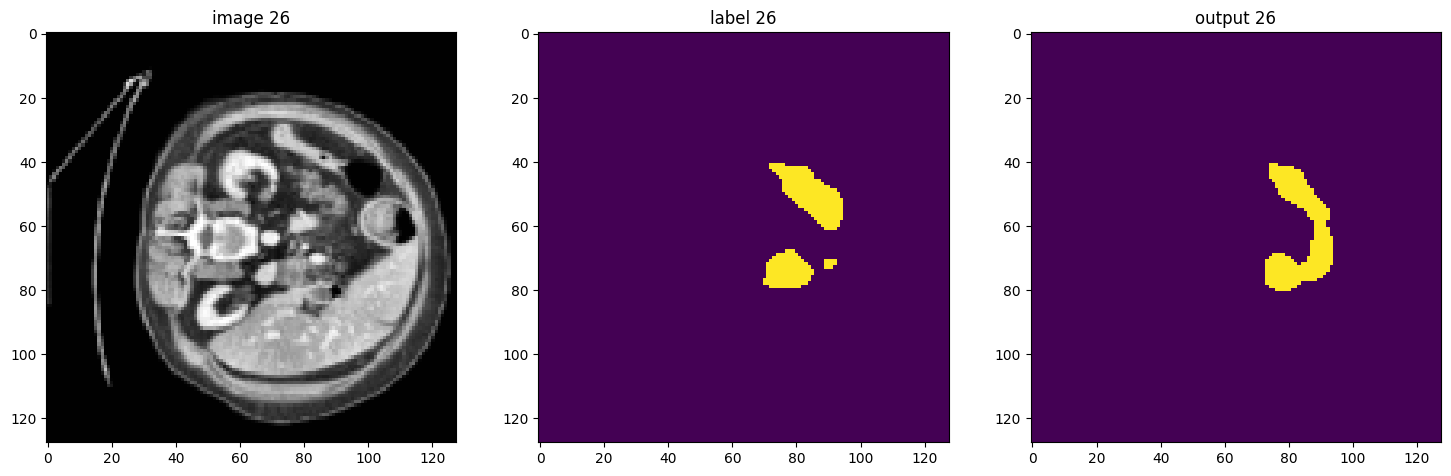

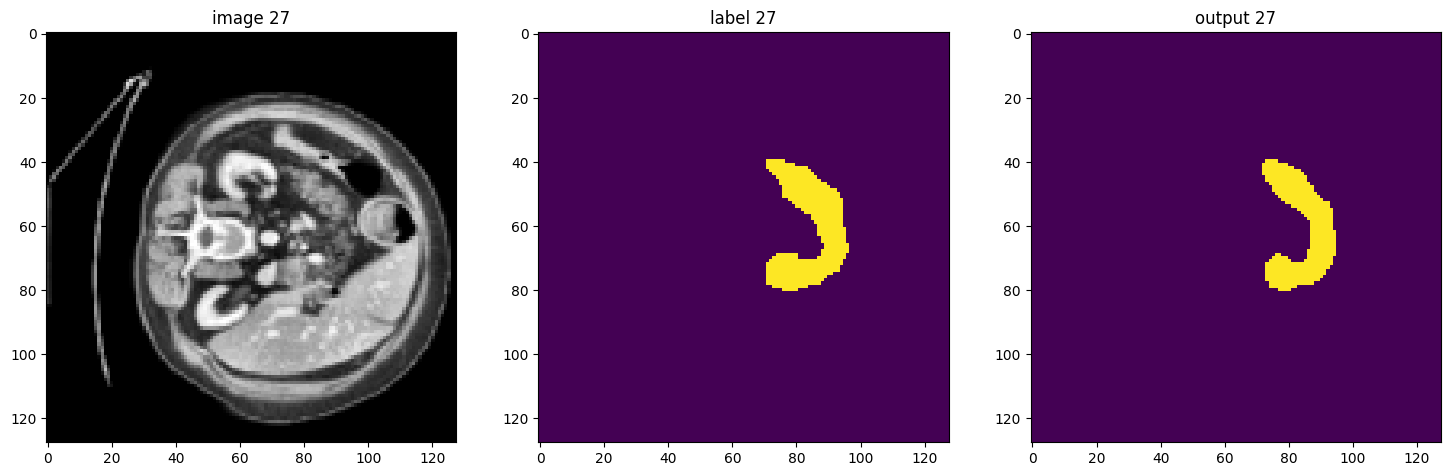

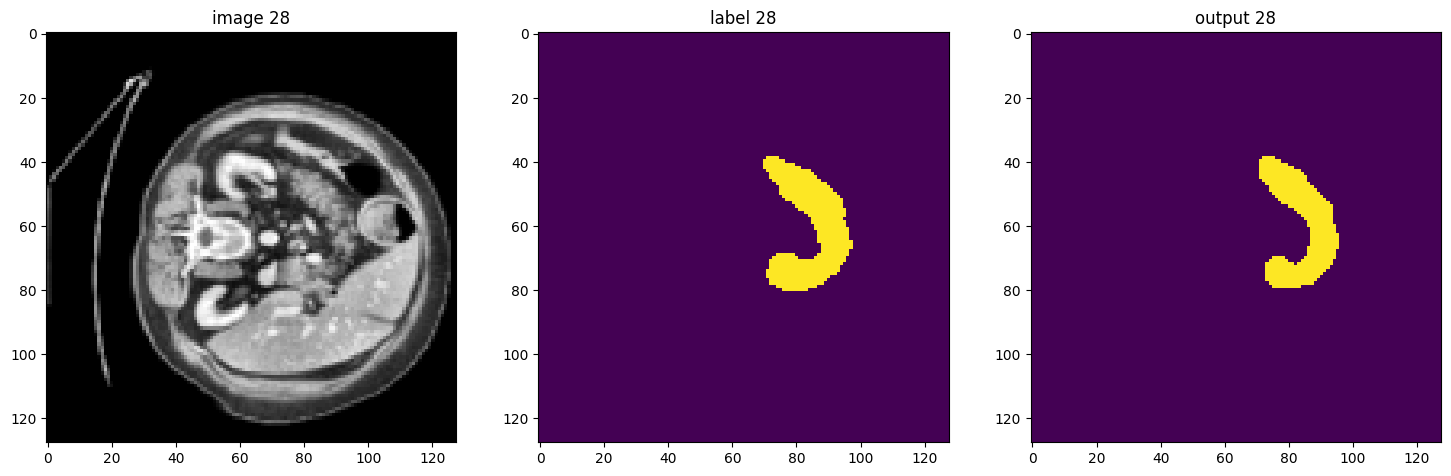

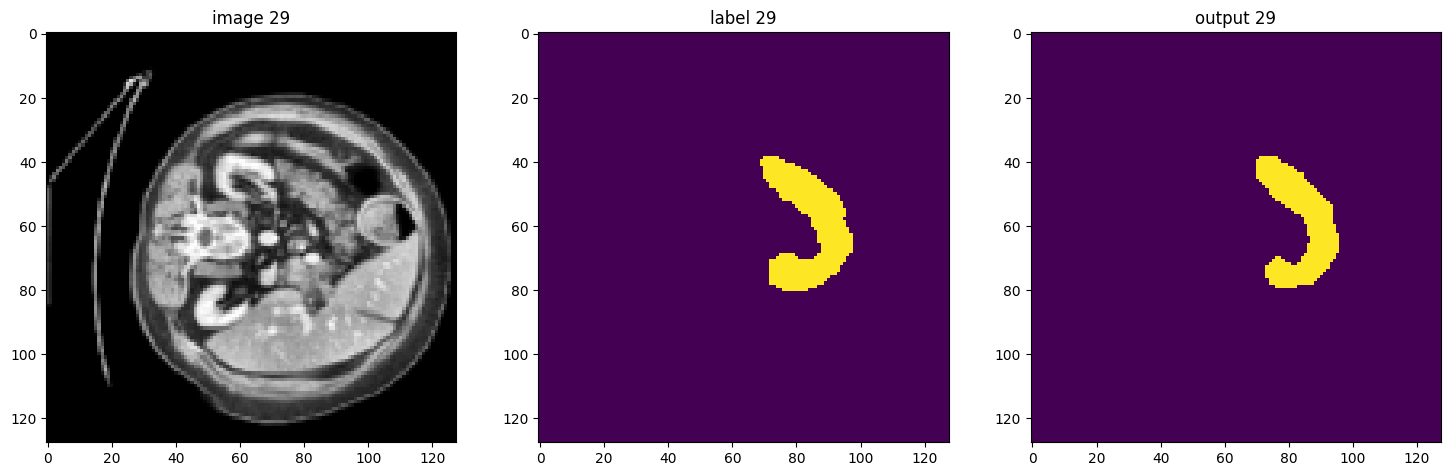

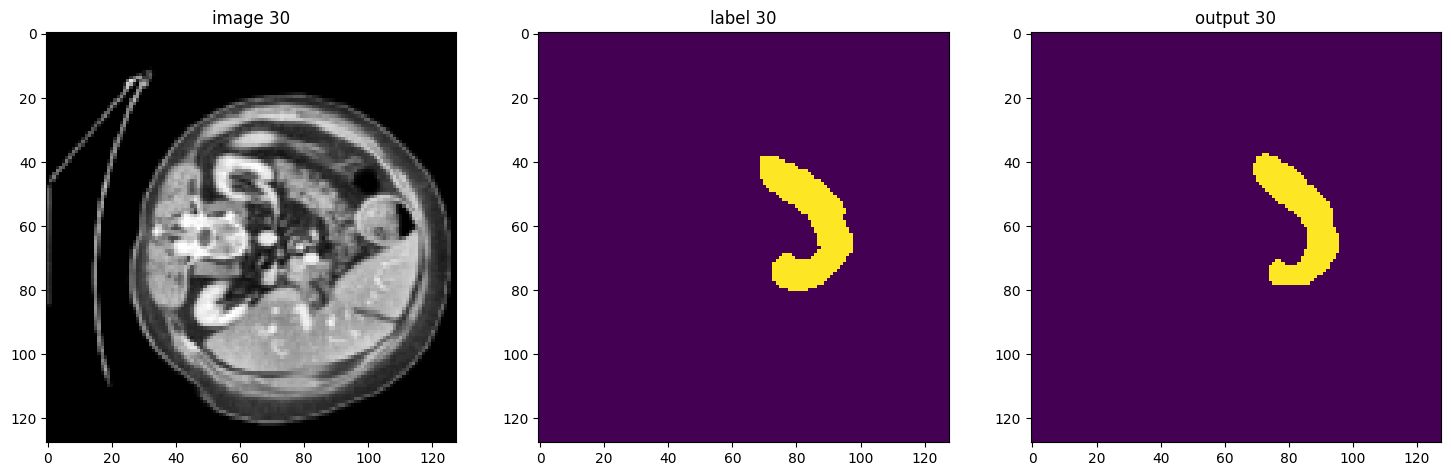

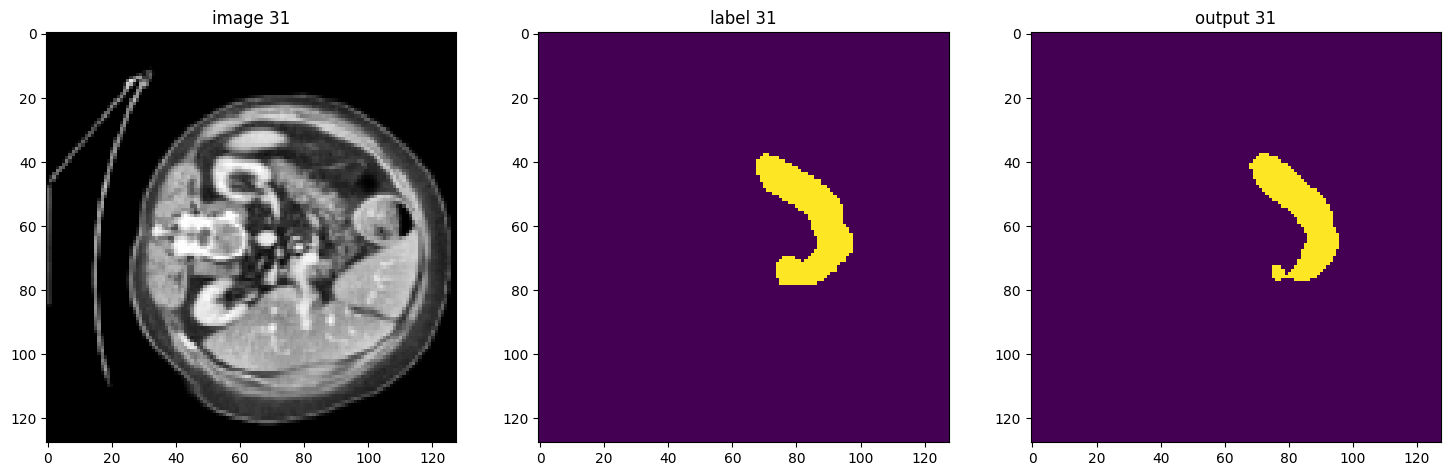

In [13]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53

    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()

## With Slider

In [ ]:
from matplotlib.colors import ListedColormap
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import numpy as np

# Define the colormap
# colors = [[0., 0., 0., 0.], [0., 1., 0., 0.3], [0.9, 0., 0., 0.3]]
colors = [[0., 0., 0., 0.], [0., 0.5, 0., 0.5], [0.9, 0., 0., 0.3]]
my_cmap = ListedColormap(colors)

def plot_slices(slice_number):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Get the slices
    test_patient = first(test_loader)
    image_slice = test_patient["vol"][0, 0, :, :, slice_number]
    label_slice = test_patient["seg"][0, 0, :, :, slice_number]
    output_slice = test_outputs.detach().cpu()[0, 1, :, :, slice_number]

    # Original image
    axes[0].imshow(image_slice, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Original label
    overlay_label = np.zeros_like(image_slice)
    overlay_label[label_slice > 0] = 1
    axes[1].imshow(image_slice, cmap='gray')
    axes[1].imshow(overlay_label, cmap=my_cmap)
    axes[1].set_title("Original Label")
    axes[1].axis('off')

    # Output segmentation
    overlay_output = np.zeros_like(image_slice)
    overlay_output[output_slice > 0] = 1
    axes[2].imshow(image_slice, cmap='gray')
    axes[2].imshow(overlay_output, cmap=my_cmap)
    axes[2].set_title("Output Segmentation")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

slice_slider = IntSlider(min=0, max=test_patient["vol"].shape[-1] - 1, value=0)
interact(plot_slices, slice_number=slice_slider)

interactive(children=(IntSlider(value=0, description='slice_number', max=63), Output()), _dom_classes=('widget…

<function __main__.plot_slices(slice_number)>